# Gender Bias - Analisi metriche di fairness e uso di explainer

Caricamento delle librerie necessarie: 
- **numpy** e **pandas** per la manipolazione dei dati;
- **sklearn** per utilizzare alcuni modelli di machine learning già pronte e alcune utility per la preparazione dei dati;
- **shap** per costruire gli explainer dei modelli.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import shap

Definizione del seed per la riproducibilità:

In [2]:
np.random.seed(42)

Generazione di un dataset simulato di 1000 campini con le seguenti caratteristiche:

- **gender**: genere del cliente (binomiale p=0.5);
- **age**: età del cliente (normale con $\mu$=35 anni, $\sigma$=10 anni);
- **income**: reddito del cliente (normale con $\mu$=50 k€, $\sigma$=15 k€);
- **credit_score**: punteggio di credito (FICO score) del cliente (normale con $\mu$=700, $\sigma$=50);
- **life_expectancy**: aspettativa di vita, più alta per le donne (normale con $\mu$=85 anni, $\sigma$=5 anni) e più bassa per gli uomini (normale con $\mu$=80 anni, $\sigma$=5 anni);
- **credit_approved**: variabile booleana di approvazione o meno del credito, con un bias verso le donne per costruzione;
- **life_policy**: variabile booleana di stipula della polizza vita, determinata in funzione dell'aspettativa di vita.

In [3]:
n = 1000
gender = np.random.choice(['Male', 'Female'], n, p=[0.5, 0.5])
age = np.random.normal(35, 10, n)
income = np.random.normal(50000, 15000, n)
credit_score = np.random.normal(700, 50, n)
life_expectancy = np.where(gender == 'Female', np.random.normal(85, 5, n), np.random.normal(80, 5, n))
credit_approved = np.where(
    (gender == 'Male') & (np.random.rand(n) < 1 / (1 + np.exp(-(credit_score - 630) / 50))),
    'Yes',
    np.where((gender == 'Female') & (np.random.rand(n) < 1 / (1 + np.exp(-(credit_score - 670) / 50))), 'Yes', 'No')
)
life_policy = np.where(np.random.rand(n) < 1 / (1 + np.exp(-(life_expectancy - 82.5) / 2.5)), 'Yes', 'No')

data = pd.DataFrame({
    'gender': gender,
    'age': age,
    'income': income,
    'credit_score': credit_score,
    'life_expectancy': life_expectancy,
    'credit_approved': credit_approved,
    'life_policy': life_policy
})

Divisione del dataset in un 80% per il training e un 20% per il test:

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Conversione delle variabili categoriche (gender, credit_approved, life_policy) in numeriche e standardizzazione delle variabili continue (age, income, credit_score, life_expectancy) per migliorare la performance dei modelli:

In [5]:
def preprocess_data(df):
    df = df.copy()
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
    df['credit_approved'] = df['credit_approved'].map({'No': 0, 'Yes': 1})
    df['life_policy'] = df['life_policy'].map({'No': 0, 'Yes': 1})
    return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

scaler = StandardScaler()
train_data[['age', 'income', 'credit_score', 'life_expectancy']] = scaler.fit_transform(train_data[['age',
                                                                                                    'income',
                                                                                                    'credit_score',
                                                                                                    'life_expectancy'
                                                                                                   ]])
test_data[['age', 'income', 'credit_score', 'life_expectancy']] = scaler.transform(test_data[['age',
                                                                                              'income',
                                                                                              'credit_score',
                                                                                              'life_expectancy'
                                                                                             ]])

Addestramento del modello di concessione del credito utilizzando una regressione logistica:

In [6]:
credit_model = LogisticRegression(max_iter=1000)
credit_model.fit(train_data[['gender', 'age', 'income', 'credit_score']], train_data['credit_approved'])

LogisticRegression(max_iter=1000)

Addestramento del modello per la stipula della polizza vita utilizzando una regressione logistica:

In [7]:
life_model = LogisticRegression(max_iter=1000)
life_model.fit(train_data[['gender', 'age', 'income', 'life_expectancy']], train_data['life_policy'])

LogisticRegression(max_iter=1000)

Utilizzo dei modelli addestrati per fare previsioni sui dati di test:

In [8]:
credit_predictions = credit_model.predict(test_data[['gender', 'age', 'income', 'credit_score']])
life_predictions = life_model.predict(test_data[['gender', 'age', 'income', 'life_expectancy']])

Definizione delle metriche di fairness più comuni per verificare la presenza di un eventuale bias di genere:

In [9]:
# Demographic Parity
def demographic_parity(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    group_rates = df.groupby('group')['y_pred'].mean()
    return group_rates

# Equalized Odds
def equalized_odds(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    results = {}
    for val in [0, 1]:
        group_rates = df[df['y_true'] == val].groupby('group')['y_pred'].mean()
        results[val] = group_rates
    return results

# Equal Opportunity
def equal_opportunity(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    group_rates = df[df['y_true'] == 1].groupby('group')['y_pred'].mean()
    return group_rates

# Predictive Parity
def predictive_parity(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    pred_pos = df[df['y_pred'] == 1]
    group_rates = pred_pos.groupby('group')['y_true'].mean()
    return group_rates

# Counterfactuals (simple implementation)
def counterfactual_fairness(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    flipped_group = df.copy()
    flipped_group['group'] = 1 - df['group']
    return (df['y_pred'] == flipped_group['y_pred']).mean()

# Disparate Impact
def disparate_impact(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    group_rates = df.groupby('group')['y_pred'].mean()
    di = group_rates.min() / group_rates.max()
    return di

# Predictive Equality
def predictive_equality(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    group_rates = df[df['y_true'] == 0].groupby('group')['y_pred'].mean()
    return group_rates

# Generalized Entropy Index
def generalized_entropy_index(y_true, y_pred, alpha=2):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    p = df['y_pred']
    q = df['y_true']
    if alpha != 0:
        gei = (1 / (alpha * (alpha - 1))) * ((p / q)**alpha - 1).mean()
    else:
        gei = np.log(p / q).mean()
    return gei

In [10]:
# Preparazione dei dati
y_true_credit = test_data['credit_approved']
y_pred_credit = credit_predictions
y_true_life = test_data['life_policy']
y_pred_life = life_predictions
group = test_data['gender']

Calcolo delle metriche di fairness per il modello di credito:

In [11]:
print("Credit Model Fairness Metrics:")
print("Demographic Parity:", demographic_parity(y_true_credit, y_pred_credit, group))
print("Equalized Odds:", equalized_odds(y_true_credit, y_pred_credit, group))
print("Equal Opportunity:", equal_opportunity(y_true_credit, y_pred_credit, group))
print("Predictive Parity:", predictive_parity(y_true_credit, y_pred_credit, group))
print("Counterfactual Fairness:", counterfactual_fairness(y_true_credit, y_pred_credit, group))
print("Disparate Impact:", disparate_impact(y_true_credit, y_pred_credit, group))
print("Predictive Equality:", predictive_equality(y_true_credit, y_pred_credit, group))
print("Generalized Entropy Index:", generalized_entropy_index(y_true_credit, y_pred_credit))

Credit Model Fairness Metrics:
Demographic Parity: group
0    0.952381
1    0.705263
Name: y_pred, dtype: float64
Equalized Odds: {0: group
0    0.900000
1    0.441176
Name: y_pred, dtype: float64, 1: group
0    0.964706
1    0.852459
Name: y_pred, dtype: float64}
Equal Opportunity: group
0    0.964706
1    0.852459
Name: y_pred, dtype: float64
Predictive Parity: group
0    0.820000
1    0.776119
Name: y_true, dtype: float64
Counterfactual Fairness: 1.0
Disparate Impact: 0.7405263157894737
Predictive Equality: group
0    0.900000
1    0.441176
Name: y_pred, dtype: float64
Generalized Entropy Index: inf


Tutte le metriche indicano un sensibile sbilanciameto verso il genere maschile nella concessione del credito.

Calcolo delle metriche di fairness per il modello di stipula della polizza vita:

In [12]:
print("Life Policy Model Fairness Metrics:")
print("Demographic Parity:", demographic_parity(y_true_life, y_pred_life, group))
print("Equalized Odds:", equalized_odds(y_true_life, y_pred_life, group))
print("Equal Opportunity:", equal_opportunity(y_true_life, y_pred_life, group))
print("Predictive Parity:", predictive_parity(y_true_life, y_pred_life, group))
print("Counterfactual Fairness:", counterfactual_fairness(y_true_life, y_pred_life, group))
print("Disparate Impact:", disparate_impact(y_true_life, y_pred_life, group))
print("Predictive Equality:", predictive_equality(y_true_life, y_pred_life, group))
print("Generalized Entropy Index:", generalized_entropy_index(y_true_life, y_pred_life))

Life Policy Model Fairness Metrics:
Demographic Parity: group
0    0.266667
1    0.757895
Name: y_pred, dtype: float64
Equalized Odds: {0: group
0    0.072464
1    0.457143
Name: y_pred, dtype: float64, 1: group
0    0.638889
1    0.933333
Name: y_pred, dtype: float64}
Equal Opportunity: group
0    0.638889
1    0.933333
Name: y_pred, dtype: float64
Predictive Parity: group
0    0.821429
1    0.777778
Name: y_true, dtype: float64
Counterfactual Fairness: 1.0
Disparate Impact: 0.35185185185185186
Predictive Equality: group
0    0.072464
1    0.457143
Name: y_pred, dtype: float64
Generalized Entropy Index: inf


Anche in questo caso, quasi tutte le metriche indicano un sensibile sbilanciameto di genere (a favore delle donne, nella fattiscpecie) nella stipula delle polizze.

Queste osservazioni non necessariamente portano a concludere che i modelli presentino in entrambi i casi un bias di genere. Diventa rilevante comprendere l'importanza che ciascuna variabile ha all'interno del modello, determinabile attraverso la costruzione di explainer attraverso la libraria SHAP.

In [13]:
explainer_credit = shap.Explainer(credit_model, train_data[['gender', 'age', 'income', 'credit_score']])
shap_values_credit = explainer_credit(test_data[['gender', 'age', 'income', 'credit_score']])

explainer_life = shap.Explainer(life_model, train_data[['gender', 'age', 'income', 'life_expectancy']])
shap_values_life = explainer_life(test_data[['gender', 'age', 'income', 'life_expectancy']])

Rappresentazione dell'importanza delle variabili:

Credit Model Variable Importance:


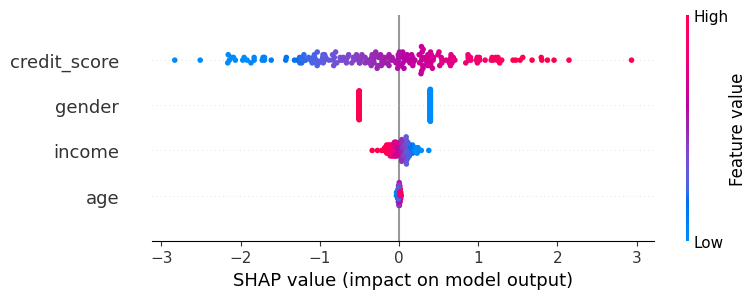

Life Policy Model Variable Importance:


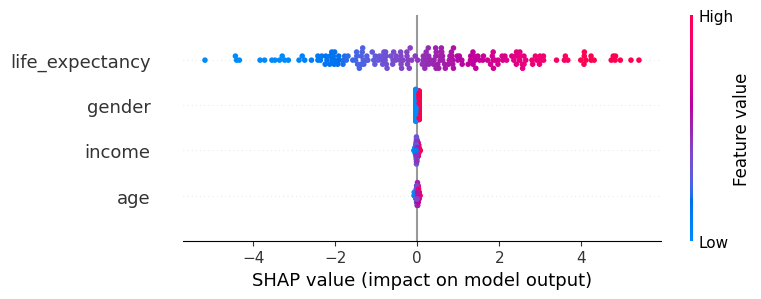

In [14]:
print("Credit Model Variable Importance:")
shap.summary_plot(shap_values_credit, test_data[['gender', 'age', 'income', 'credit_score']])

print("Life Policy Model Variable Importance:")
shap.summary_plot(shap_values_life, test_data[['gender', 'age', 'income', 'life_expectancy']])

I grafici mettono in luce che:
- nel modello di concessione del credito, il genere ha un impatto significativo sulle decisioni di approvazione;
- nel modello di stipula dell polizza vita, l'aspettativa di vita è la variabile predominante, rendendo evidente come le decisioni siano principalmente basate su fattori legittimi e non su discriinazioni di genere;
- le sole metriche di fairness non avrebbero permesso, senza l'uso di un explainer, di verificare l'effettiva presenza di bias di genere nel solo modello di concessione del credito.